In [1]:
pip install nelson_siegel_svensson

Note: you may need to restart the kernel to use updated packages.


In [2]:
import os
import pandas as pd
import numpy as np
from nelson_siegel_svensson.calibrate import calibrate_ns_ols
import matplotlib.pyplot as plt
from scipy.interpolate import CubicSpline

#M1 L3

In [3]:
directory = r"C:\Users\kaleu\Desktop\WQU\raw data"
#Data Source: https://www.investing.com/rates-bonds/

dfs = {}

for filename in os.listdir(directory):
    if filename.endswith(".csv"):
        file_path = os.path.join(directory, filename)
        df = pd.read_csv(file_path, usecols=['Date','Price'])
        dfs[filename] = df['Price']
dfs = pd.DataFrame(dfs)

Date = pd.read_csv(file_path, usecols=['Date'])
dfs.columns = ['0.25','0.5','10','15','1','20','3','5','7']

dfs =dfs.set_index(pd.to_datetime(Date['Date']))

desired_order = ['0.5', '1', '3', '5', '7', '10', '15', '20']
dfs = dfs[desired_order]

In [4]:
t = np.array([0.5, 1, 3, 5, 7, 10, 15, 20])
y = np.array(dfs.loc["2025-09-23"]).flatten()

In [5]:
# Fit an NS model for yields from 2025-09-23
curve, status = calibrate_ns_ols(t, y, tau0=1)  # starting value of 1.0 for the optimization of tau
assert status.success
print(curve)

NelsonSiegelCurve(beta0=3.7992774942086287, beta1=-0.5993007289261909, beta2=-3.4502480514319434, tau=1.7229730591717987)


Text(0.5, 1.0, 'NS Model Result')

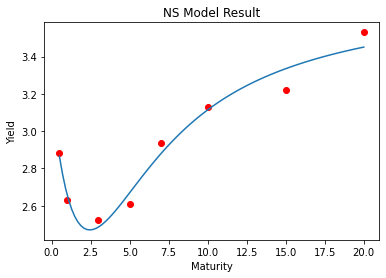

In [6]:
y_hat = curve
t_hat = np.linspace(0.5,20,100)
plt.plot(t_hat, y_hat(t_hat))
plt.scatter(t, y, color='red', label='Actual Data', marker='o')
plt.xlabel("Maturity")
plt.ylabel("Yield")
plt.title("NS Model Result")

In [7]:
# Using Scipy
cs = CubicSpline(t, y, bc_type='natural')

Text(0.5, 1.0, 'Cubic Spline Fit to Yield Data')

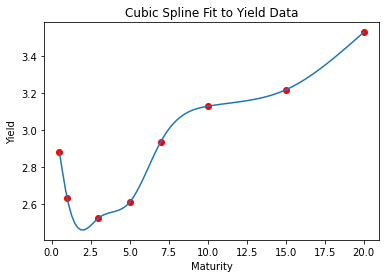

In [8]:
t_hat = np.linspace(0.5, 20, 100) 
y_spline = cs(t_hat)
plt.plot(t_hat, y_spline, label='Cubic Spline Fit')
plt.scatter(t, y, color='red', label='Actual Data', marker='o')
plt.xlabel("Maturity")
plt.ylabel("Yield")
plt.title("Cubic Spline Fit to Yield Data")

In [9]:
#For ease of demonstration, we will only use yields from 0.5-year, 3-year, 10-year, and 20 year bond data

t = np.array([0.5,3,10,20])
y = np.array([2.881,2.523,3.129,3.53])

In [10]:

# Create output vector y (out variable) and squared matrix A (input variable)
out = np.array([2.881,2.523,2.523,3.129,3.129,3.53,0,0,0,0,0,0])
input = np.array([[0.125, 0.25, 0.5, 1,0,0,0,0,0,0,0,0], \
                  [27, 9, 3, 1,0,0,0,0,0,0,0,0], \
                  [0,0,0,0,27, 9, 3, 1,0,0,0,0], \
                  [0,0,0,0,1000,100,10,1,0,0,0,0], \
                  [0,0,0,0,0,0,0,0,1000,100,10,1], \
                  [0,0,0,0,0,0,0,0,8000, 400, 20, 1], \
                  [27,6,1,0,-27,-6,-1,0,0,0,0,0], \
                  [0,0,0,0,300,20,1,0,-300,-20,-1,0], \
                  [18,2,0,0,-18,-2,0,0,0,0,0,0], \
                  [0,0,0,0,60,2,0,0,-60,-2,0,0], \
                  [3,2,0,0,0,0,0,0,0,0,0,0], \
                  [0,0,0,0,0,0,0,0,120,2,0,0]])

In [11]:
# Solve for coefficient vector and reshape to an 3 by 4 array (lines variable)
# Make sure to give enough decimals since all coefficients are relatively small. If there is not decimal points, the following coefficient results and graphs will be rough
lines = np.round(np.dot(np.linalg.inv(input), out).reshape(-1,4),decimals=8)
pd.DataFrame(lines)
#columns[a,b,c,d]
#row[1,2,3]

,0,1,2,3
0,0.005452,-0.008178,-0.173188,2.968957
1,-0.002543,0.063783,-0.389071,3.184840
2,0.000417,-0.025039,0.499144,0.224123


In [12]:
# Calculates x**0 + x**1 + x**2 + x**3
def plot_num(values, coeffs):
    # Coeffs are assumed to be in order 0, 1, ..., n-1
    expanded = np.hstack([coeffs[i] * (values ** i) for i in range(0, len(coeffs))])
    return np.sum(expanded, axis=1)

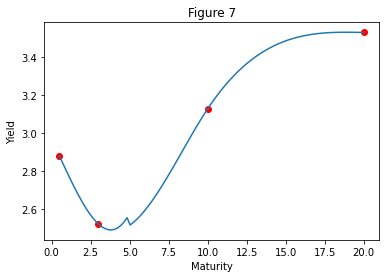

In [13]:
# Simulate the 100 paired data points and draw the graph
xs = np.linspace(0.5,20, 100)

y1s = plot_num(xs[xs<5].reshape(-1,1), lines[0][::-1])
y2s = plot_num(xs[(xs>=5) & (xs<10)].reshape(-1,1), lines[1][::-1])
y3s = plot_num(xs[xs>=10].reshape(-1,1), lines[2][::-1])
ys = np.concatenate([y1s, y2s, y3s])


plt.plot(xs, ys)
plt.scatter(t, y,c="red")
plt.xlabel("Maturity")
plt.ylabel("Yield")
plt.title("Figure 7")
plt.show()

Q: Compare the models in terms of 1) fi t and 2) interpretation.



Answer:

1) Fit

NS : We can observe that not perfect fit all the observed data, 1 smooth curve that pass through all the point

CS : Show the ability in fitting observed data, potential to have a "kink" in the fitted line

2) Interpretation

a) NS better on the interpretability , since the fitted line is smoothed, it could produce a more explainable result. NS also can handle the extrapolation question, Since CS is interpolation, when doing out of sample calculation it might be not well define, however for NS it is parametric method, it could provide a result for out of sample input. 

b) NS also provide intuition meaning for model parameters, according to M1L3, 
𝜆 is the decay rate. The decay rate is between 0 and 1. 
𝛽0 is used to describe the level of the yield curve.
𝛽1 is used to describe the slope of the yield curve and
𝛽2 is used to describe shape of the yield curve.
  


Q: In Module 2 Lesson 4 (‘Smoothing Data’), we said smoothing data can be unethical. If Nelson-Siegel is smoothing the yield curve, is this considered unethical? Why or why not?

Answer:
If Nelson-Siegel is smoothing the yield curve, this is not necessarily considered as unethical.

a) The smoothing is not intended to mislead the true. The smoothing is by construction of the model design. It is also intend to produce a interpretable representation of the yield curve for analysis.

b) In Econometrics, you will smooth time series to filter out noise. Nelson-Siegel can filter out the noise to prevent overfiting. So the intention is not unethical.